# EDA on the efap site on a PROGRAM LEVEL

In [1]:
import pandas as pd

In [2]:
efap = pd.read_csv('/Users/ayemaq/Desktop/CID_Food_Access/data/clean/efap_cleaned.csv')
mapping = pd.read_csv('/Users/ayemaq/Desktop/CID_Food_Access/data/clean/efap_nta_mapping.csv')
df = efap.merge(mapping, on="efap_id", how="left")

In [3]:
import sqlite3
import pandas as pd

# Connect to your database
conn = sqlite3.connect("/Users/ayemaq/Desktop/CID_Food_Access/data/food_access.db")

In [ ]:
df.shape

(561, 10)

In [5]:
df['nta_id'].isna().sum()

8

#### insight:
8 out of 561 EFAP sites (1.4%) did not map to an NTA. Because this represents a small proportion of total sites, we proceed by excluding these records from neighborhood-level aggregation.

In [6]:
df[df["nta_id"].isna()]

,efap_id,program_name,access_type,has_pantry_access,has_kitchen_access,weekday_available,weekend_available,nta_id,lat,lon
54,81727,AFRICAN SERVICES COMMITTEE,Pantry,1,0,1,0,NaN,NaN,NaN
123,87357,ST. EDWARD FOOD PANTRY,Pantry,1,0,1,0,NaN,NaN,NaN
440,85774,NEW BEGINNINGS FOOD PANTRY,Pantry,1,0,1,0,NaN,NaN,NaN
468,80891,CORPUS CHRISTI FOOD PANTRY,Pantry,1,0,1,0,NaN,NaN,NaN
474,85348,THE LEGACY CENTER COMMUNITY DEVELOPMENT CORP,Pantry,1,0,1,0,NaN,NaN,NaN
517,85284,"VETS INC, HOLLIS GARDENS",Pantry,1,0,1,0,NaN,NaN,NaN
537,83567,"THE HARDING FORD VISION, INC",Pantry,1,0,1,1,NaN,NaN,NaN
550,85710,MUNA SOCIAL SERVICE SOUTH JAMAICA,Pantry,1,0,1,0,NaN,NaN,NaN


In [7]:
df = df.dropna(subset=["nta_id"])
print(df["nta_id"].isna().sum())

0


8 EFAP sites (1.4% of total) lacked geospatial coordinates (latitude and longitude), and therefore could not be mapped to an NTA. Because neighborhood-level aggregation requires valid geographic identifiers, these records were excluded from subsequent analysis. This exclusion represents a minimal proportion of total sites and is unlikely to materially affect results.

In [8]:
mapping["efap_id"].nunique()
mapping.shape

(553, 4)

# CONTEXT - Program-Level EFAP Structure and Access Model
The EFAP dataset represents the supply-side structure of New York City’s emergency food assistance system. At the program level, each site is categorized by its access type, primarily distinguishing between pantry access (take-home groceries) and kitchen access (prepared hot meals). Pantry programs provide groceries such as canned goods, rice, pasta, or produce, which households are expected to store and prepare themselves. Kitchen programs, in contrast, provide prepared meals on-site, typically consumed the same day. Some programs may offer both, but the distinction between pantry and kitchen access reflects fundamentally different models of food support.

If the EFAP system is predominantly pantry-based, this suggests that the city’s emergency food infrastructure is structured around assumptions of household stability and food preparation capacity. Pantry programs implicitly assume that recipients have access to refrigeration, food storage, cooking appliances, and predictable routines for meal preparation. In contrast, kitchen-based programs provide immediate, ready-to-eat meals and require fewer household-level resources, making them more accessible for individuals or families without consistent cooking facilities.

This distinction is especially important in the context of families living in shelters. Shelter conditions vary by facility type. Some family shelters, including commercial hotel placements, may offer limited or no in-room kitchen access, shared facilities with restricted hours, or minimal storage capacity. In such contexts, a pantry-dominant food assistance system may not align with the lived realities of shelter residents. While pantry programs increase food availability, they may not translate into functional access if families lack the means to safely store or prepare groceries. Kitchen-based programs may better support immediate food needs for families with constrained living arrangements.

Therefore, analyzing the distribution of pantry versus kitchen access within EFAP is not merely descriptive. It provides insight into the underlying design of the city’s food assistance system and allows us to evaluate whether the structure of supply aligns with the housing instability and facility constraints experienced by families in shelters. This structural lens strengthens our later neighborhood-level analysis by clarifying what “food access” functionally means before examining where programs are geographically located.

## Context - why I created  specific binary indictors such as pantry acccess or kitchen access 
- While access_type provides categorical information about the service model, separate binary indicators (has_pantry_access, has_kitchen_access) were engineered to allow clearer analytical and modeling flexibility. These flags preserve overlap for hybrid sites and enable direct measurement of pantry and kitchen capacity without requiring categorical encoding. This structure simplifies aggregation and supports later neighborhood-level modeling of supply composition.

In [9]:
df.keys()

Index(['efap_id', 'program_name', 'access_type', 'has_pantry_access',
       'has_kitchen_access', 'weekday_available', 'weekend_available',
       'nta_id', 'lat', 'lon'],
      dtype='object')

In [10]:
# let's check the distribution using .value_counts(), .value_counts(normalize=True) 
# to see %'s and .crosstab to compare categorical variables 

# check distribution of access_type
df["access_type"].value_counts()

access_type
Pantry              444
Kitchen              81
Pantry + Kitchen     28
Name: count, dtype: int64

In [11]:
df["access_type"].value_counts(normalize=True)

access_type
Pantry              0.802893
Kitchen             0.146474
Pantry + Kitchen    0.050633
Name: proportion, dtype: float64

In [12]:
print(df["has_pantry_access"].mean() * 100)
print(df["has_kitchen_access"].mean() * 100)


85.35262206148282
19.710669077757686


### Insight for distribution 
- The distribution of access types shows that approximately 80% of EFAP programs are pantry-only, 15% are kitchen-only, and 5% provide both pantry and kitchen access. When examining access flags more broadly, 85% of programs offer pantry access (including hybrid sites), while only about 20% offer kitchen access. This indicates that NYC’s EFAP system is heavily structured around a take-home grocery model rather than prepared meal distribution.

- Side note: The predominance of pantry-based EFAP programs suggests a supply model centered on take-home food preparation, which may not fully align with the constraints faced by families in shelter settings with limited cooking and storage access.
    - This makes me ask why do they priotrize pantries? However that's scope creeping because our CRQ is not "Why is the system pantry dominant?” but "Do high-priority neighborhoods have fewer food assistance options?"! 

## Next is to look at temporal accessbility - weekend, weekday 
- Which access type has the highest weekend availability rate?

In [13]:
# crosstab to compare access_type and weekend avabilibity 
pd.crosstab(
    df["access_type"],
    df["weekend_available"],
    normalize="index"
) * 100

weekend_available,0,1
access_type,,
Kitchen,65.432099,34.567901
Pantry,66.891892,33.108108
Pantry + Kitchen,82.142857,17.857143


#### Key takeaway
- Among kitchen sites, 34.6% are weekend available.
- Among pantry sites, 33.1% are weekend available.
- Among hybrid sites, 17.9% are weekend available.
    - Weekend availability appears structurally limited across all access types, and hybrid sites are the least likely to operate on weekends.

In [14]:
pd.crosstab(
    df["access_type"],
    df['weekday_available'],
    normalize="index"
) * 100


weekday_available,0,1
access_type,,
Kitchen,28.395062,71.604938
Pantry,25.000000,75.000000
Pantry + Kitchen,7.142857,92.857143


In [15]:
pd.crosstab(df["access_type"], df["weekday_available"])

weekday_available,0,1
access_type,,
Kitchen,23,58
Pantry,111,333
Pantry + Kitchen,2,26


In [16]:
pd.crosstab(df["access_type"], df["weekend_available"])

weekend_available,0,1
access_type,,
Kitchen,53,28
Pantry,297,147
Pantry + Kitchen,23,5


##### Key takeaway
- While pantry-based programs dominate NYC’s EFAP system, temporal accessibility reveals an even stronger structural pattern: 
    - the vast majority of programs operate on weekdays, while weekend availability is limited across all access types. Notably, hybrid (Pantry + Kitchen) sites are highly likely to operate on weekdays (~93%) but are among the least likely to offer weekend services (~18%). This suggests that temporal flexibility is concentrated during the workweek, potentially limiting access for families whose schedules or shelter constraints make weekday attendance difficult.

In [17]:
df.head()

,efap_id,program_name,access_type,has_pantry_access,has_kitchen_access,weekday_available,weekend_available,nta_id,lat,lon
0,80604,HOLY APOSTLES SOUP KITCHEN,Kitchen,0,1,1,0,MN0401,40.749385,-73.999131
1,85547,HOLY APOSTLES SOUP KITCHEN PANTRY,Pantry,1,0,1,0,MN0401,40.749385,-73.999131
2,80757,ST. JOHN'S BREAD OF LIFE,Pantry,1,0,1,0,MN0501,40.748690,-73.992824
3,85701,ARTISTS ATHLETES ACTIVISTS INCORPORATED,Pantry,1,0,1,0,MN0302,40.718893,-73.979216
4,80546,DEWITT REFORMED CHURCH,Pantry,1,0,0,1,MN0302,40.717508,-73.979751


In [18]:
count_programs = df.groupby('program_name').size().sort_values(ascending=False)
count_programs

program_name
AAIDS CENTER OF QUEENS COUNTY                3
HOLY TABERNACLE CHURCH INC.                  2
MAKE THE ROAD NEW YORK                       2
ST. ANN'S CHURCH OF MORRISANIA               2
THE URBAN OUTREACH CENTER OF NYC             2
                                            ..
COMMUNITY HEALTH ACTION OF STATEN ISLAND     1
COMMUNITY CHURCH OF CHRIST FOOD PANTRY       1
COMMUNITY CARE FOOD PANTRY                   1
COMMUNITY ALLIANCE INITIATIVE                1
ZEINA LORRAINE INC                           1
Length: 506, dtype: int64

In [19]:
# print counts where its >1
count_programs.value_counts()

1    460
2     45
3      1
Name: count, dtype: int64

#### key takeaway
The EFAP supply system is highly decentralized. Approximately 91% of program names operate a single site, with only 9% operating more than one location. Multi-site operators account for roughly 17% of total sites, indicating limited structural concentration within the system.

# NTA level

In [ ]:
# create a total_sites per nta column to see how many EFAP sites exist within each NTA.
total_sites = (df.groupby("nta_id")["efap_id"].nunique().reset_index().rename(columns={"efap_id": "total_sites"}))
total_sites["total_sites"].value_counts().sort_index()

total_sites
1     41
2     24
3     22
4     19
5     15
6      9
7      8
8      6
9      3
10     1
12     3
16     1
Name: count, dtype: int64

In [ ]:
print(total_sites.shape)          # should be (152, 2)
print(total_sites["nta_id"].nunique())  # should be 152

(152, 2)
152


##### Key takeaway on how many NTAs have X number of sites?
- 41 NTAs have exactly 1 site
- 24 NTAs have exactly 2 sites
- 22 NTAs have exactly 3 sites
- 19 NTAs have exactly 4 sites
- 1 NTA has 16 sites and etc..

There are 152 NTAs that contain at least one EFAP site. Among those 152:
- The most common situation is 1 site.
- There are some moderately dense NTAs (5–8 sites).
- There is at least one very dense NTA (16 sites).
    - So supply is not evenly distributed. It is right-skewed.

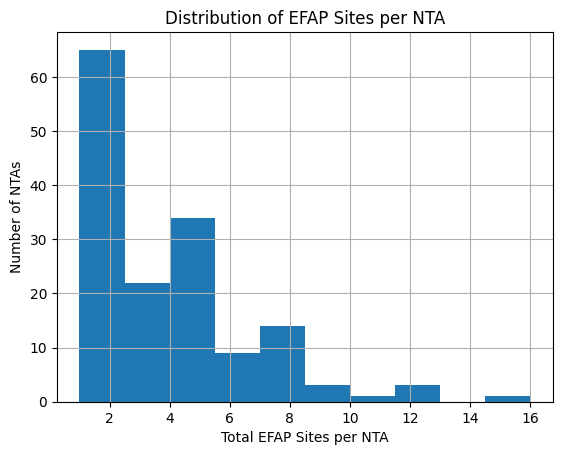

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
total_sites["total_sites"].hist()
plt.xlabel("Total EFAP Sites per NTA")
plt.ylabel("Number of NTAs")
plt.title("Distribution of EFAP Sites per NTA")
plt.show()

##### Key takeway
The distribution of EFAP sites per NTA is right-skewed, with most neighborhoods containing only 1–3 sites and a small number of NTAs exhibiting significantly higher concentrations (10+ sites). This indicates uneven geographic distribution of food assistance supply across NYC.

### Next step
Right now, I know that supply is uneven. But concentration can mean two things:
- Some NTAs have many sites OR many NTAs have very few sites.
- lets check what is the median vs the mean of total_sites?

In [23]:
total_sites["total_sites"].describe()

count    152.000000
mean       3.638158
std        2.739337
min        1.000000
25%        1.000000
50%        3.000000
75%        5.000000
max       16.000000
Name: total_sites, dtype: float64

##### Key takeaway:
- 25% of NTAs have 1 site only.
- 50% or half of NTAs have 3 or fewer EFAP sites.
- 75% of NTAs have 5 or fewer.
- A few NTAs stretch up to 16 sites.

So basically supply is uneven but not dominated by extreme outliers. There are some higher-density neighborhoods but most sit between 1 and 5 sites. This is nuanced.

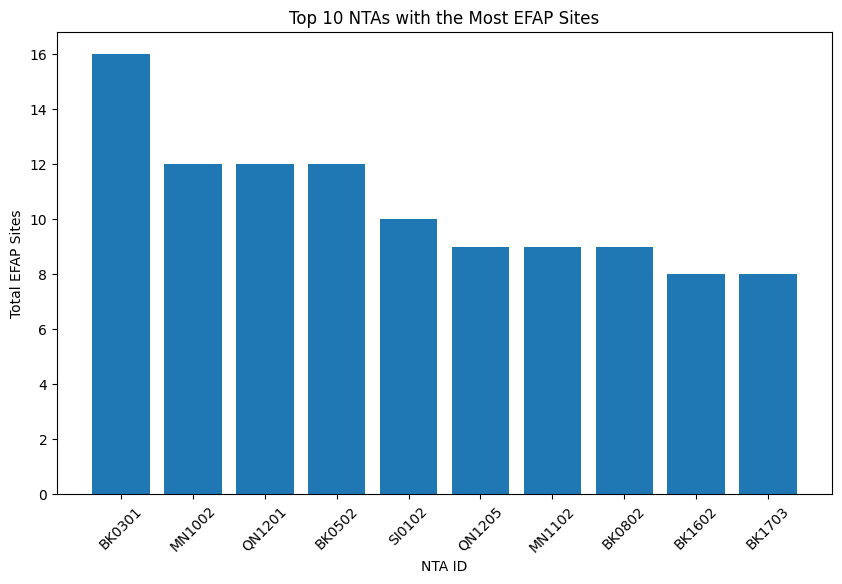

In [24]:
# create a visual to see the top ten nta with the most efap sites.
top_10_ntas = total_sites.sort_values(by="total_sites", ascending=False).head(10)
plt.figure(figsize=(10, 6))
plt.bar(top_10_ntas["nta_id"], top_10_ntas["total_sites"])
plt.xlabel("NTA ID")
plt.ylabel("Total EFAP Sites")
plt.title("Top 10 NTAs with the Most EFAP Sites")
plt.xticks(rotation=45)
plt.show()

### Next step - show pantry vs kitchen distribution across all NTAs first

In [25]:
# group by nta_id and sum the has_pantry_access and has_kitchen_access columns to see how many sites have pantry and kitchen access within each NTA.
access_summary = df.groupby("nta_id")[["has_pantry_access", "has_kitchen_access"]].sum().sort_index()
access_summary  

,has_pantry_access,has_kitchen_access
nta_id,,
BK0101,1,0
BK0102,1,0
BK0103,1,0
BK0104,1,0
BK0202,2,1
...,...,...
SI0201,1,0
SI0202,1,0
SI0203,1,1


In [ ]:
ntas_no_kitchen = access_summary[access_summary["has_kitchen_access"] == 0]
print(ntas_no_kitchen.shape[0])

81


In [27]:
percent_no_kitchen = (
    ntas_no_kitchen.shape[0] / access_summary.shape[0]
) * 100

print(percent_no_kitchen)


53.289473684210535


In [28]:
ntas_no_pantry = access_summary[access_summary["has_pantry_access"] == 0]
print(ntas_no_pantry.shape[0])


2


In [29]:
percent_no_pantry = (
    ntas_no_pantry.shape[0] / access_summary.shape[0]
) * 100

print(percent_no_pantry)


1.3157894736842104


##### Key takeaway
There 81 NTAs that have 0 kitchen accesss which is ~53% of neighborhoods. Now only 2 NTAs have 0 pantry access which is ~1.3% of neighborhooods. So citywide, pantry access is nearly universal across neighborhoods, while kitchen access is missing in more than half. This is a structural imbalance because remember from my previous findings at program-level, we saw ~80% were pantry dominant. But at the neighborhood level we're seeing kitchens are absent in over half of NTA's, this is more powerful framing as this means the imblaance isn't just about proportions of programs but also about geographic absence. Some neighborhoods literally have no hot-meal infrastructure at all (I will double check this). So its different from "fewer kitchens than patnries". 

In [30]:
# Merge total_sites into access_summary so So each NTA has: total_sites, has_kitchen_access (count), has_pantry_access (count)
access_summary = access_summary.merge(total_sites, on="nta_id", how="left")

In [31]:
import numpy as np

# binary flag: does this NTA have ANY kitchen access?
access_summary["has_any_kitchen"] = (access_summary["has_kitchen_access"] > 0).astype(int)

# compare mean + median total sites
summary_stats = (access_summary.groupby("has_any_kitchen")["total_sites"].agg(["count", "mean", "median"]))
summary_stats

,count,mean,median
has_any_kitchen,,,
0,81,2.580247,2.0
1,71,4.845070,4.0


##### Key takeaway
- Across 152 NTAs, 81 neighborhoods, or about 53%, have no kitchen access at all, while 71 NTAs, or about 47 percent, have at least one kitchen site. When we compare total EFAP site counts, neighborhoods without kitchen access have an average of 2.58 total sites, with a median of 2 sites. In contrast, neighborhoods with at least one kitchen have an average of 4.85 total sites and a median of 4 sites. This shows that kitchen access is not evenly distributed across the city. Instead, it tends to appear in neighborhoods that already have a stronger overall food assistance presence. In other words, neighborhoods with weaker EFAP infrastructure are also the least likely to have hot meal options, suggesting that differences in access are not just about pantry versus kitchen proportions, but about broader geographic concentration of food assistance resources.

In [33]:
import geopandas as gpd
import pandas as pd
from shapely import wkt

dim_map = pd.read_csv("/Users/ayemaq/Desktop/CID_Food_Access/data/clean/dim_map.csv")

# convert WKT string to geometry
dim_map["the_geom_wkt"] = dim_map["the_geom_wkt"].apply(wkt.loads)

# convert to GeoDataFrame
gdf = gpd.GeoDataFrame(dim_map, geometry="the_geom_wkt")


In [ ]:
gdf = gdf.merge(access_summary, on="nta_id", how="left")

In [35]:
gdf[["has_pantry_access", "has_kitchen_access"]] = \
gdf[["has_pantry_access", "has_kitchen_access"]].fillna(0)

In [36]:
def access_category(row):
    if row["has_pantry_access"] > 0 and row["has_kitchen_access"] > 0:
        return "Both"
    elif row["has_pantry_access"] > 0:
        return "Pantry Only"
    elif row["has_kitchen_access"] > 0:
        return "Kitchen Only"
    else:
        return "No Access"

gdf["access_category"] = gdf.apply(access_category, axis=1)

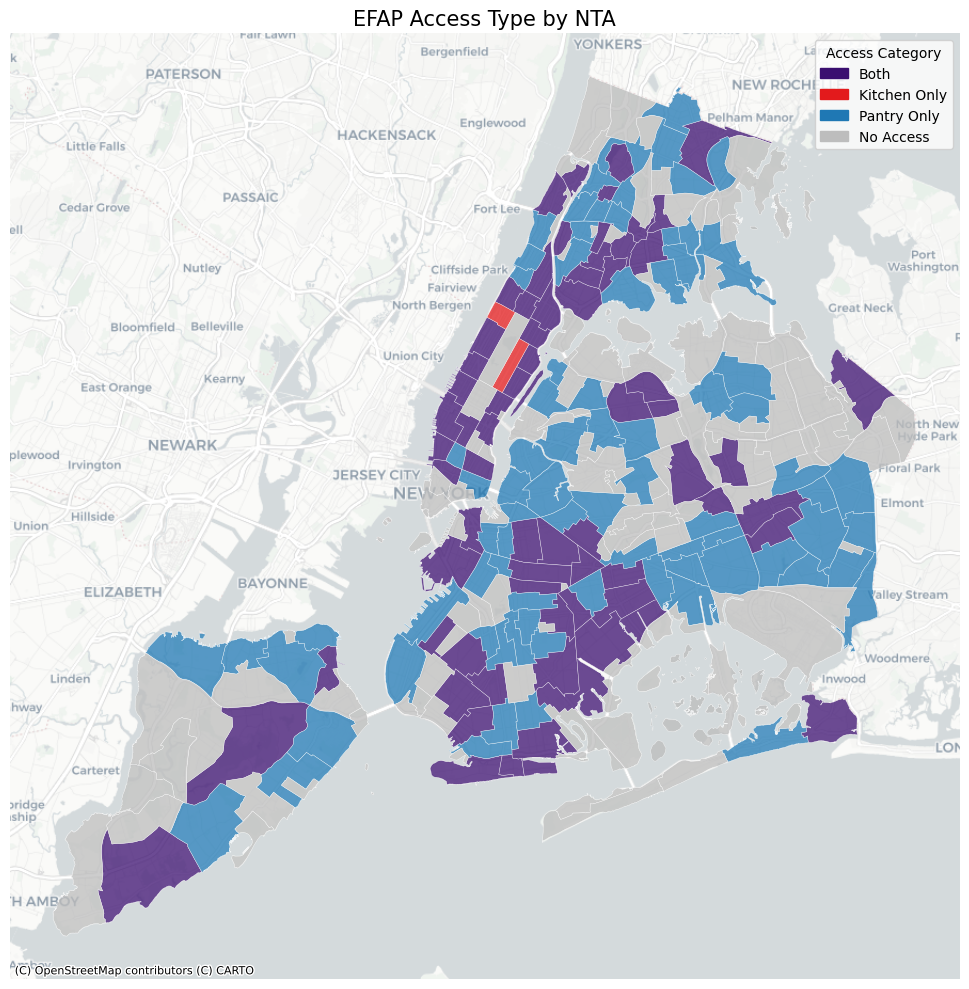

In [43]:
import matplotlib.pyplot as plt
import contextily as cx
import matplotlib.patches as mpatches

gdf_web = gdf.to_crs(epsg=3857)

color_dict = {
    "Both": "#3B0F70",
    "Kitchen Only": "#E31A1C",
    "Pantry Only": "#1F78B4",
    "No Access": "#BDBDBD"
}

fig, ax = plt.subplots(figsize=(10, 10))

for category, color in color_dict.items():
    gdf_web[gdf_web["access_category"] == category].plot(
        ax=ax,
        color=color,
        alpha=0.75,
        edgecolor="white",
        linewidth=0.3
    )

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

ax.set_axis_off()
ax.set_title("EFAP Access Type by NTA", fontsize=15)

# ✅ Custom legend that works with GeoPandas
legend_handles = [
    mpatches.Patch(color=color, label=category)
    for category, color in color_dict.items()
]
ax.legend(handles=legend_handles, title="Access Category", loc="upper right")

plt.tight_layout()
plt.show()


### main key takeaway
 When we look at EFAP access across all NTAs citywide, the first thing that stands out is that the distribution is uneven, but not chaotic. The median number of sites per NTA is 3, and most neighborhoods have five or fewer sites. A few neighborhoods go up to 16, which pulls the average up to 3.6, but that’s not the norm. So overall, resources are somewhat concentrated in certain areas, while most neighborhoods are operating with relatively limited infrastructure.

When we map access types, we see that most neighborhoods fall into either “Pantry Only” or “Both Pantry and Kitchen.” Kitchen-only neighborhoods are extremely rare, which aligns with what we saw numerically. There are also a noticeable number of “No Access” NTAs, and those are not evenly spread across the city.

Visually, Brooklyn shows a mix of “Both” and “Pantry Only,” meaning there is at least some infrastructure present in most areas. Manhattan also has strong clustering of “Both,” which makes sense given density and service concentration. Queens, however, stands out. There are more NTAs marked as “No Access” there compared to other boroughs. Now, that does not automatically mean inequity. Some of those areas may not have high shelter density or may not be historically high-need zones. So the absence of EFAP sites there could be aligned with lower demand. We cannot conclude mismatch yet without layering in prioritization and shelter data.

So overall takeaway: EFAP infrastructure is not evenly distributed, but it is not randomly distributed either. It appears clustered in certain boroughs and sparse in others. The map suggests patterns that need to be interpreted in context, especially once we join this with neighborhood prioritization and shelter census data.

### Weekend and Weekday on an NTA - level

In [ ]:
df["weekday_available"] = df["weekday_available"].astype(int)
df["weekend_available"] = df["weekend_available"].astype(int)

# build NTA-level fact table: total_sites, weekday_site_count, weekend_site_count, I asked co-pilot to help me create this
nta_fact = (
    df.groupby("nta_id").agg(
          total_sites=("efap_id", "nunique"),
          weekday_site_count=("weekday_available", "sum"),
          weekend_site_count=("weekend_available", "sum")
      ).reset_index()
)
nta_fact.head()

,nta_id,total_sites,weekday_site_count,weekend_site_count
0,BK0101,1,1,0
1,BK0102,1,1,0
2,BK0103,1,1,0
3,BK0104,1,1,0
4,BK0202,3,2,1


In [45]:
# value counts: how many NTAs have 0 weekend sites, 1 weekend site, etc.
nta_fact["weekend_site_count"].value_counts().sort_index()

# summary stats
nta_fact[["total_sites", "weekday_site_count", "weekend_site_count"]].describe()

,total_sites,weekday_site_count,weekend_site_count
count,152.000000,152.000000,152.000000
mean,3.638158,2.743421,1.184211
std,2.739337,2.233095,1.309269
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000
50%,3.000000,2.000000,1.000000
75%,5.000000,4.000000,2.000000
max,16.000000,12.000000,7.000000


##### Key takeaway
- Weekday Access Is Much More Common Than Weekend Access. Average weekday sites per NTA: 2.74 and average weekend sites per NTA: 1.18
    - Even though the average NTA has around 3 to 4 total sites, only about 1 of them is open on weekends.
    - That tells us weekend access is structurally more limited.
- How many NTAs have 0 weekend access: Minimum weekend sites = 0 so that's 25% of NTAs have 0 weekend sites
    - That means at least a quarter of neighborhoods have no weekend food access at all.

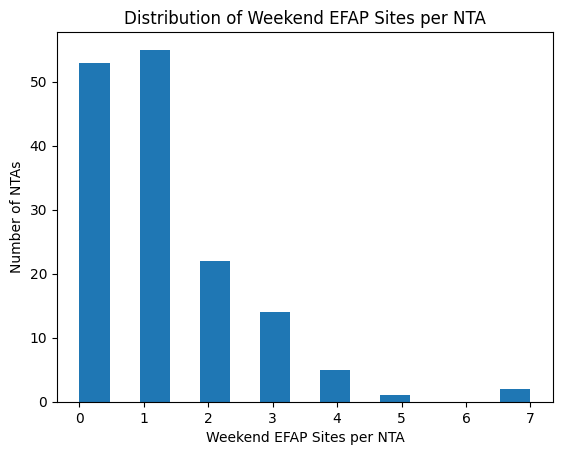

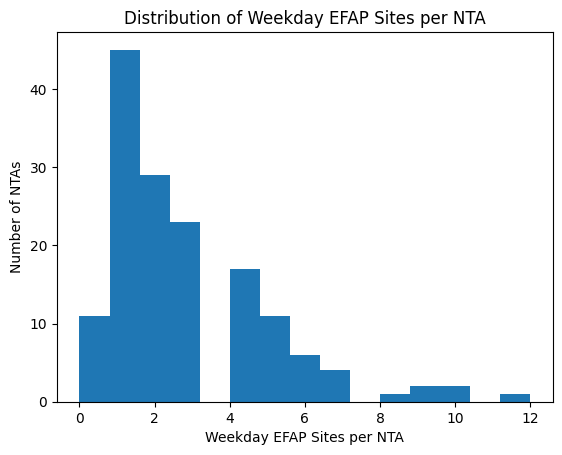

In [ ]:
plt.figure()
plt.hist(nta_fact["weekend_site_count"], bins=15)
plt.title("Distribution of Weekend EFAP Sites per NTA")
plt.xlabel("Weekend EFAP Sites per NTA")
plt.ylabel("Number of NTAs")
plt.show()

plt.figure()
plt.hist(nta_fact["weekday_site_count"], bins=15)
plt.title("Distribution of Weekday EFAP Sites per NTA")
plt.xlabel("Weekday EFAP Sites per NTA")
plt.ylabel("Number of NTAs")
plt.show()

##### Key takeaway
- The distribution of **weekend EFAP** sites shows that weekend access is extremely limited across most NTAs. A large number of neighborhoods have 0 weekend sites, and many others have only 1. After that, the numbers drop off quickly. Only a small number of NTAs have 3 or more weekend sites, and just one or two reach as high as 5 or 7. This aligns with the summary statistics, where the average weekend site count is about 1.18, the median is 1, and the maximum is 7. Overall, this tells us that weekend food access is much more constrained and uneven compared to total site availability, meaning many neighborhoods have very limited support on Saturdays and Sundays.
- **Weekday EFAP** access looks noticeably stronger than weekend access. The average number of weekday sites per NTA is about 2.74, with a median of 2, and some neighborhoods reaching as high as 12 weekday sites. Most NTAs fall between 1 and 4 weekday sites, and while a few have 0, that number is much smaller compared to weekend gaps. The distribution is right-skewed, meaning a small number of neighborhoods have a high concentration of weekday programs, while most have modest coverage. Overall, this shows that food assistance infrastructure is much more available during the week than on weekends, reinforcing that weekend access is where the real constraint lies.

In [ ]:
num_zero_weekend = (nta_fact["weekend_site_count"] == 0).sum()
pct_zero_weekend = num_zero_weekend / nta_fact.shape[0] * 100

num_zero_weekday = (nta_fact["weekday_site_count"] == 0).sum()
pct_zero_weekday = num_zero_weekday / nta_fact.shape[0] * 100

print("NTAs with 0 weekend sites:", num_zero_weekend, f"({pct_zero_weekend:.1f}%)")
print("NTAs with 0 weekday sites:", num_zero_weekday, f"({pct_zero_weekday:.1f}%)")

NTAs with 0 weekend sites: 53 (34.9%)
NTAs with 0 weekday sites: 11 (7.2%)


In [ ]:
nta_fact["has_any_weekend"] = (nta_fact["weekend_site_count"] > 0).astype(int)

compare_weekend = (
    nta_fact.groupby("has_any_weekend")["total_sites"]
            .agg(count="count", mean="mean", median="median")
)
compare_weekend

,count,mean,median
has_any_weekend,,,
0,53,1.943396,1.0
1,99,4.545455,4.0


In [ ]:
nta_fact["has_any_weekday"] = (nta_fact["weekday_site_count"] > 0).astype(int)

compare_weekday = (
    nta_fact.groupby("has_any_weekday")["total_sites"]
            .agg(count="count", mean="mean", median="median")
)
compare_weekday

,count,mean,median
has_any_weekday,,,
0,11,1.636364,1.0
1,141,3.794326,3.0


#### Key takeaway
When we compare NTAs with and without weekend access, the difference is pretty big. There are 53 NTAs with zero weekend sites, and those neighborhoods have an average of only 1.94 total sites overall, with a median of 1. Meanwhile, the 99 NTAs that do have at least one weekend site average 4.45 total sites, with a median of 4. So weekend access isn’t random. It tends to exist in neighborhoods that already have more overall food infrastructure.

Now look at weekdays. Only 11 NTAs have zero weekday sites, compared to 53 with zero weekend sites. And the 141 NTAs with weekday access have an average of 3.79 total sites, versus just 1.63 in NTAs without weekday access. Again, weekday access is much more widespread.

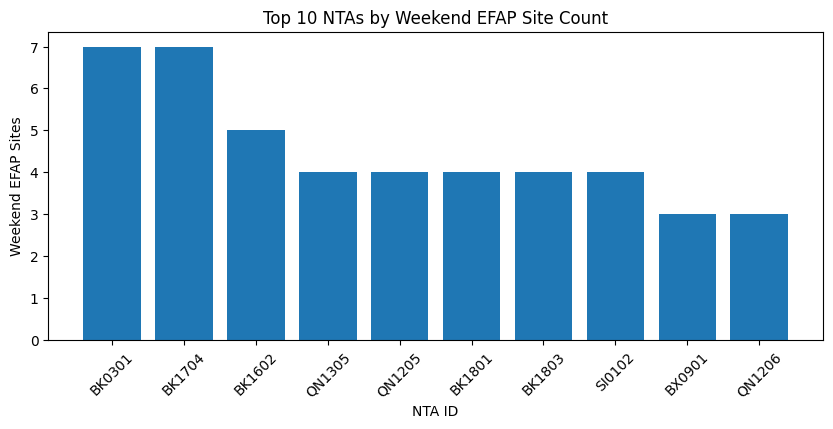

In [ ]:
top_weekend = nta_fact.sort_values("weekend_site_count", ascending=False).head(10)

plt.figure(figsize=(10,4))
plt.bar(top_weekend["nta_id"], top_weekend["weekend_site_count"])
plt.title("Top 10 NTAs by Weekend EFAP Site Count")
plt.xlabel("NTA ID")
plt.ylabel("Weekend EFAP Sites")
plt.xticks(rotation=45)
plt.show()

# SUMMARY OF EDA
### I asked gpt to give me a summary divided into sections


## 1. Data Cleaning and Geospatial Mapping

- 8 out of 561 EFAP sites (1.4%) could not be mapped to an NTA due to missing coordinates.
- Because this represents a very small proportion of total sites, these records were excluded from neighborhood-level aggregation.
- After cleaning, 152 NTAs contain at least one EFAP site.

**Key takeaway:** Data integrity is strong, and the small exclusions are unlikely to materially affect results.

---

## 2. Program-Level Structure (Pantry vs Kitchen)

- ~80% of programs are pantry-only.
- ~15% are kitchen-only.
- ~5% provide both pantry and kitchen access.
- ~85% of programs offer pantry access (including hybrid sites).
- ~20% offer kitchen access.

**Key takeaway:** NYC’s EFAP system is structurally pantry-dominant. The system is primarily designed around take-home grocery distribution rather than prepared meal service.

---

## 3. Temporal Accessibility (Weekday vs Weekend)

- Weekend availability is limited across all access types.
- Hybrid (Pantry + Kitchen) sites are highly weekday-oriented (~93%) but rarely operate on weekends (~18%).
- Pantry and kitchen sites also show limited weekend availability (~33–35%).

**Key takeaway:** The system is heavily weekday-dependent. Access is not just about food type, but also about when services are available.

---

## 4. Program Concentration

- ~91% of program names operate a single site.
- Only ~9% operate multiple sites.
- Multi-site operators account for ~17% of total EFAP sites.

**Key takeaway:** The EFAP system is highly decentralized, with most providers operating only one location.

---

## 5. NTA-Level Supply Distribution

Across 152 NTAs with at least one EFAP site:

- 41 NTAs have exactly 1 site.
- 50% of NTAs have 3 or fewer sites.
- 75% have 5 or fewer sites.
- The maximum observed is 16 sites in one NTA.
- Mean = 3.6 sites per NTA.
- Median = 3 sites per NTA.

**Key takeaway:** Supply is uneven but nuanced. Most neighborhoods operate with relatively limited infrastructure (1–5 sites), while a small number of NTAs have higher concentrations. The distribution is right-skewed but not dominated by extreme outliers.

---

## 6. Pantry vs Kitchen Access at the Neighborhood Level

- 81 NTAs (53%) have zero kitchen access.
- Only 2 NTAs (~1.3%) have zero pantry access.
- NTAs without kitchen access:
  - Average total sites = 2.58
  - Median = 2
- NTAs with kitchen access:
  - Average total sites = 4.85
  - Median = 4

**Key takeaway:** Kitchen access is geographically absent in more than half of neighborhoods. Additionally, kitchen infrastructure tends to appear in NTAs that already have stronger overall EFAP presence. Neighborhoods with weaker overall supply are also less likely to have hot-meal options.

---

## 7. Spatial Patterns (Map-Level Insights)

- Manhattan shows clustering of NTAs with both pantry and kitchen access.
- Brooklyn shows a mix of “Both” and “Pantry Only.”
- Queens contains a noticeable number of “No Access” NTAs.
- Kitchen-only NTAs are extremely rare.

**Key takeaway:** EFAP infrastructure is not randomly distributed. It appears spatially clustered in certain boroughs and sparse in others. However, geographic absence alone does not imply inequity without comparing supply to neighborhood-level need.

---

## Overall Summary

The EFAP system in NYC is pantry-dominant, weekday-oriented, decentralized, and geographically uneven. While some NTAs have concentrated food infrastructure, most neighborhoods operate with relatively limited supply. Kitchen access, in particular, is absent in over half of NTAs and tends to cluster in neighborhoods that already have stronger EFAP presence. 

These findings establish a structural understanding of supply. The next step is to evaluate whether this supply aligns with neighborhood-level prioritization and indicators of food insecurity.
